# CITS3401 Project 2 Report
## Eddie Atkinson (22487668)

## Introduction
The purpose of the previous exercise was to produce clean, aggregated data and load it into a database where it could be efficiently queried, manipulated and visualised. This component of the project is focused on analysing that data to discover useful and previous unknown trends and patterns using a variety of techniques, including association rule mining, classification, numerosity reduction, and machine learning.

## Initial Data Cleaning
Data is stored in the database in normalised tables as part of its snowflake schema. In order to perform analytics on the data it is necessary to denormalise the data, remerging it into a central dataframe. The data used for this analysis is contained in the CSV files that were used to load the data into the database in part one of the assignment, however it is easy to imagine a situation where data would be exported in bulk from MSSQL to CSVs using the export wizard.   

To start, the data must be loaded into dataframes, remembering that the "~" separator was used on the data for ease of use in the SQL loading scripts:

In [1]:
# Set autoreload, everything is a pain otherwise
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

dim_country = pd.read_csv("data/dim_country.csv", sep="~")
dim_education = pd.read_csv("data/dim_education.csv", sep="~")
dim_person = pd.read_csv("data/dim_person.csv", sep="~")
dim_race = pd.read_csv("data/dim_race.csv", sep="~")
dim_relationship = pd.read_csv("data/dim_relationship.csv", sep="~")
dim_work = pd.read_csv("data/dim_work.csv", sep="~")
fact_income = pd.read_csv("data/fact_income.csv", sep="~")

# Have a look at some of the dataframes to check the reading was successful
print(fact_income.head())
print(dim_person.head())

   person_id  capital_gain  capital_loss  hours_pw
0          0          2174             0        40
1          1             0             0        38
2          2             0             0        65
3          3             0             0        37
4          4             0             0        40
   person_id  race_id  country_id  work_id  education_id  relationship_id  \
0          0        0           0        0             0                0   
1          1        0           0        0             0                0   
2          2        0           0        0             0                0   
3          3        0           0        0             0                0   
4          4        0           0        0             0                0   

  gender income_bracket  age  
0      M          <=50K   39  
1      M          <=50K   37  
2      F          <=50K   24  
3      M          <=50K   32  
4      M          <=50K   44  


To demerge the data, a central dataframe is incrementally constructed by merging the dataframes on their ID columns and then removing the ID columns from the data set. We'll start by constructing the central dataframe by merging ```dim_person``` with ```fact_income```. 

In [3]:
central_df = fact_income
central_df = central_df.merge(dim_person, on=["person_id"], how="left")
# Drop the person ID, it is no longer needed
central_df.drop(["person_id"], axis=1, inplace=True)
# Have a look at the dataframe to check all went well
print(central_df.head())

   capital_gain  capital_loss  hours_pw  race_id  country_id  work_id  \
0          2174             0        40        0           0        0   
1             0             0        38        0           0        0   
2             0             0        65        0           0        0   
3             0             0        37        0           0        0   
4             0             0        40        0           0        0   

   education_id  relationship_id gender income_bracket  age  
0             0                0      M          <=50K   39  
1             0                0      M          <=50K   37  
2             0                0      F          <=50K   24  
3             0                0      M          <=50K   32  
4             0                0      M          <=50K   44  


Now that the central, remerged dataframe has been created, the rest of the dimensions can be merged into it following the same pattern of merging based on IDs followed by ID deletion.

In [4]:
# Process dim_country
central_df = central_df.merge(dim_country, on=["country_id"], how="left")
# Delete country ID
central_df.drop(["country_id"], axis=1, inplace=True)

# Process dim_education
central_df = central_df.merge(dim_education, on=["education_id"], how="left")
# Delete education ID
central_df.drop(["education_id"], axis=1, inplace=True)

# Process dim_race
central_df = central_df.merge(dim_race, on=["race_id"], how="left")
central_df.drop(["race_id"], axis=1, inplace=True)

# Process dim_relationship
central_df = central_df.merge(dim_relationship, on=["relationship_id"], how="left")
central_df.drop(["relationship_id"], axis=1, inplace=True)

# Process dim_work
central_df = central_df.merge(dim_work, on=["work_id"], how="left")
central_df.drop(["work_id"], axis=1, inplace=True)

# Take a final peek at the dataset to check that it's correct
print(central_df.head())

   capital_gain  capital_loss  hours_pw gender income_bracket  age  \
0          2174             0        40      M          <=50K   39   
1             0             0        38      M          <=50K   37   
2             0             0        65      F          <=50K   24   
3             0             0        37      M          <=50K   32   
4             0             0        40      M          <=50K   44   

    country_name  education ethnicity relationship_role marital_relationship  \
0  United-States  Bachelors     White     Not-in-family        Never-married   
1  United-States  Bachelors     White     Not-in-family        Never-married   
2  United-States  Bachelors     White     Not-in-family        Never-married   
3  United-States  Bachelors     White     Not-in-family        Never-married   
4  United-States  Bachelors     White     Not-in-family        Never-married   

  marriage_status work_class    occupation  
0     Not Married  State-gov  Adm-clerical  
1     No

Now that the data has been remerged we can perform analytics. Let's start with association rule mining. 

## Association Rule Mining

Association rule mining is concerned with finding frequent item sets. Association rule mining could be helpful in the context of this dataset for finding out which characteristics are associated with being in a higher income bracket, so that people wishing to increase their income can make data-driven decisions about how to do so. 

Whether an item set is considered frequent is determined by its support - its relative frequency in the dataset. The minimum support required for an item set to be considered frequent is highly problem-specific, and so will need to be tuned as part of the analysis to discover meaningful results. 

However, it is not only the frequency of item sets that is of interest for association rule mining, but also the interaction between item sets in the dataset. The interactions of item sets are measured with two metrics - confidence and lift. Confidence measures the conditional probability of an item set containing a particular item , given that another item is contained in the item set. Lift measures the degree to which the presence of a particular item in an item set increases the occurrence of another, taking into account the popularity of both items in the dataset. Lift is a better measure than confidence as confidence can reveal associations that exist only due to the popularity of one item in the item set. Lift values greater than 1 indicate that there is a positive association between the items being compared, a lift value of 1 indicates that there is no association and a lift value below 1 indicates a negative association between the two items. 

### Aim
The aim of this analysis is to uncover association rules between particular characteristics and income status using lift as a metric, and provide recommendations to a person seeking to increase their income.

### Library Installation
To mine the association rules the ```mlxtend``` library will be used, if it is not installed on your system, uncomment the command below and run it to install it.

In [5]:
#import sys
# !{sys.executable} -m pip install mlxtend 

Before we can use the ```mlxtend``` library to mine association rules the continuous variables in the dataset must be discretised, and then all categorical variables must be converted to binary variables.  

In [6]:
discrete_df = central_df
# Find the columns that require discretising
print(discrete_df.dtypes)

capital_gain             int64
capital_loss             int64
hours_pw                 int64
gender                  object
income_bracket          object
age                      int64
country_name            object
education               object
ethnicity               object
relationship_role       object
marital_relationship    object
marriage_status         object
work_class              object
occupation              object
dtype: object


The attributes that need to be discretised are:
* Age
* Hours worked per week
* Capital Gain
* Capital Loss

In order to discretise them sensibly let's take a look at their plots.

In /home/eddie/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/eddie/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/eddie/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


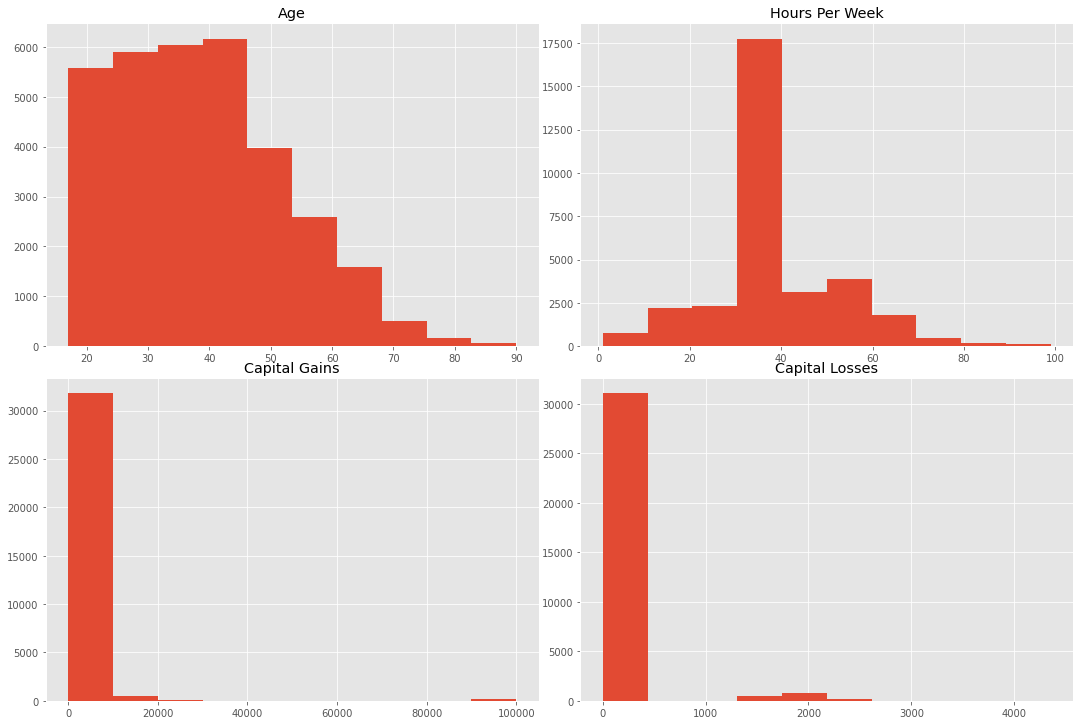

In [7]:
import matplotlib.pyplot as plt
# Matplot lib is pretty ugly, so use ggplot styling
plt.style.use("ggplot")
# Create subplot with two rows and columns with a larger plot size for ease of comparison
fig, axs = plt.subplots(2,2, figsize = (15, 10))
# Spaces the plots out so the titles don't overlap
fig.tight_layout()

# Plot age
axs[0, 0].set_title("Age")
axs[0, 0].hist(discrete_df["age"])

# Plot Hours per week
axs[0, 1].set_title("Hours Per Week")
axs[0, 1].hist(discrete_df["hours_pw"])

# Plot capital gains
axs[1, 0].set_title("Capital Gains")
axs[1, 0].hist(discrete_df["capital_gain"])

# Plot capital losses
axs[1, 1].set_title("Capital Losses")
axs[1, 1].hist(discrete_df["capital_loss"])

plt.show()


Looking at the histograms the following discretisation schemes appear logical and easily interpretable:

- Age: Divide age into bins of size 10 with a maximum of 100.
- Hours worked per week: Divide hours worked per week into bins of size 10, with a maximum of 100.
- Capital gains: Divide capital gains into bins of size 10,000 with a maximum of 100,000.
- Capital losses: Divide capital losses into bins of size 1,000 with a maximum of 5,000.

In [8]:
from discretise import discretise_age
from discretise import discretise_hours
from discretise import discretise_cap_gains
from discretise import discretise_cap_loss


discrete_df["age"] = discrete_df["age"].apply(lambda x: discretise_age(x))
discrete_df["hours_pw"] = discrete_df["hours_pw"].apply(lambda x: discretise_hours(x))
discrete_df["capital_gain"] = discrete_df["capital_gain"].apply(lambda x: discretise_cap_gains(x))
discrete_df["capital_loss"] = discrete_df["capital_loss"].apply(lambda x: discretise_cap_loss(x))

dummy_df = pd.get_dummies(discrete_df)
print(dummy_df.head())

   capital_gain_0-9K  capital_gain_10-19K  capital_gain_20-29K  \
0                  1                    0                    0   
1                  1                    0                    0   
2                  1                    0                    0   
3                  1                    0                    0   
4                  1                    0                    0   

   capital_gain_30-39K  capital_gain_40-49K  capital_gain_90-99K  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   capital_loss_0-1K  capital_loss_1-2K  capital_loss_2-3K  capital_loss_3-4K  \
0                  1                  0                  0                  0   
1                  1            

Now that the data is in the correct format we can perform apriori pruning to find the association rules. Through experimentation on the dataset it was found that the maximum value for ```min_support``` that produced useful rules lay between 0.18 and 0.19, reducing the ```min_support``` below 0.18 results in highly convoluted rules that provide little insight, and increasing above ```0.19``` yields no rules at all. Lift is the metric used to rank rules, and as we are looking for characteristics positively associated with having a higher income, the ```min_threshold``` value is set to ```1.01```.

In [9]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

frequent_itemsets = apriori(dummy_df, min_support=0.18, use_colnames=True) 
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.01)
print(rules.head())

              antecedents             consequents  antecedent support  \
0     (capital_gain_0-9K)              (gender_F)            0.976352   
1              (gender_F)     (capital_gain_0-9K)            0.330795   
2     (capital_gain_0-9K)  (income_bracket_<=50K)            0.976352   
3  (income_bracket_<=50K)     (capital_gain_0-9K)            0.759190   
4             (age_20-29)     (capital_gain_0-9K)            0.247351   

   consequent support   support  confidence      lift  leverage  conviction  
0            0.330795  0.326464    0.334371  1.010813  0.003492    1.005374  
1            0.976352  0.326464    0.986909  1.010813  0.003492    1.806466  
2            0.759190  0.758760    0.777138  1.023641  0.017523    1.080533  
3            0.976352  0.758760    0.999434  1.023641  0.017523   41.755474  
4            0.976352  0.246153    0.995158  1.019261  0.004652    4.883599  


We are only interested in the rules in which having an income larger than 50K is the rule's consequent, or the outcome of the rule, so we will filter the rules to include only those where having an income greater than 50K is the only outcome.

In [10]:
def row_filter(x):
    if "income_bracket_>50K" in x["consequents"] and len(x["consequents"]) == 1:
        return True
    return False

# Add a column indicating whether the consequents only contain income >=50K
rules["income_row"] = rules.apply(lambda x: row_filter(x), axis=1)
rules = rules[rules["income_row"] == True]
rules = rules.sort_values(by=["lift"], ascending=[False])
print(len(rules))

35


Now that we have a reasonable number of association rules to examine, let's print them in a readable format and interpret them.

In [11]:
from apriori import print_rules
print_rules(rules)

(country_name_United-States,marriage_status_Married,marital_relationship_Married-civ-spouse) -> (income_bracket_>50K)
Support: 0.19
Confidence: 0.46
Lift: 1.9
Antecedents count: 3


(country_name_United-States,marital_relationship_Married-civ-spouse) -> (income_bracket_>50K)
Support: 0.19
Confidence: 0.46
Lift: 1.9
Antecedents count: 2


(ethnicity_White,marital_relationship_Married-civ-spouse) -> (income_bracket_>50K)
Support: 0.19
Confidence: 0.46
Lift: 1.89
Antecedents count: 2


(marriage_status_Married,ethnicity_White,marital_relationship_Married-civ-spouse) -> (income_bracket_>50K)
Support: 0.19
Confidence: 0.46
Lift: 1.89
Antecedents count: 3


(country_name_United-States,marriage_status_Married) -> (income_bracket_>50K)
Support: 0.19
Confidence: 0.45
Lift: 1.87
Antecedents count: 2


(marriage_status_Married,gender_M,relationship_role_Husband,marital_relationship_Married-civ-spouse) -> (income_bracket_>50K)
Support: 0.18
Confidence: 0.45
Lift: 1.86
Antecedents count: 4


(gende

The top 5 rules in terms of lift appear to be convoluted and contain redundancy in terms of attributes. The first two rules differ only in that the second does not include ```marriage_status_Married```, but does include ```marital_relationship_Married-civ-spouse```, which indicates the same information, albeit more specifically. 

Given that the minimum lift threshold was set to ```1.01```, all of the mined rules indicate a positive association between the antecedents and the consequent, having an income larger than 50K per year. Therefore, to adequately answer the question of what someone seeking to increase their income should do, it is perhaps better to look at the simplest rules which are associated with a higher income, as the changes proposed by these may then be arbitrarily combined to increase the likelihood of a person earning more than \$50,000 per year.

Instead of ranking the rules by lift, we can instead list them by the number of attributes in the antecedents to identify simpler, more useful rules.  

In [12]:
rules["antecedents_count"] = rules["antecedents"].apply(lambda x: len(x))
rules = rules.sort_values(
    by=["antecedents_count", "lift"],
    ascending=[True, False]
)
print_rules(rules)

(relationship_role_Husband) -> (income_bracket_>50K)
Support: 0.18
Confidence: 0.45
Lift: 1.86
Antecedents count: 1


(marital_relationship_Married-civ-spouse) -> (income_bracket_>50K)
Support: 0.21
Confidence: 0.45
Lift: 1.86
Antecedents count: 1


(marriage_status_Married) -> (income_bracket_>50K)
Support: 0.21
Confidence: 0.44
Lift: 1.81
Antecedents count: 1


(gender_M) -> (income_bracket_>50K)
Support: 0.2
Confidence: 0.31
Lift: 1.27
Antecedents count: 1


(ethnicity_White) -> (income_bracket_>50K)
Support: 0.22
Confidence: 0.26
Lift: 1.06
Antecedents count: 1


(country_name_United-States) -> (income_bracket_>50K)
Support: 0.22
Confidence: 0.25
Lift: 1.02
Antecedents count: 1


(country_name_United-States,marital_relationship_Married-civ-spouse) -> (income_bracket_>50K)
Support: 0.19
Confidence: 0.46
Lift: 1.9
Antecedents count: 2


(ethnicity_White,marital_relationship_Married-civ-spouse) -> (income_bracket_>50K)
Support: 0.19
Confidence: 0.46
Lift: 1.89
Antecedents count: 2


(

Looking at the rules ordered by the number of attributes in the antecedents, we see similar trends to the graphs produced in the first assignment. Let's take a look at the top rules containing a single antecedent and interpret them:

- Rule 1: If a person is a husband they are 1.86 times more likely to have an income greater than \$50,000. 
- Rule 2: If a person is a civilian spouse they are 1.86 times more likely to have an income greater than \$50,000.
- Rule 3: If a person is married they are 1.81 times more likely to have an income greater than \$50,000.
- Rule 4: If a person is male they are 1.27 times more likely to have an income greater than \$50,000.
- Rule 5: If a person is white they are 1.06 times more likely to have an income greater than \$50,000.
- Rule 6: If a person is born in the United States they are 1.02 times more likely to have an income greater than \$50,000.

The support for these rules ranges from 0.18 to 0.22, suggesting that there is a reasonably large number of rows containing the antecedent, consequent, or both. 

The confidence for these rules ranges from 0.25 to 0.45, demonstrating that confidence can at times be a misleading metric for analysing association rules due to the fact that is does not account for the frequency of the antecedent and the consequent in the data set.

Looking further down the list of rules we also see that there are interactions between the parameters that produce larger lift values, for example, being a civilian spouse and born in the United States makes a person 1.9 times more likely to have an income greater than \$50,000, a larger lift value than either of those characteristics produce alone.


### Answering our initial question

In the context of the analysis performed in the first part of the assignment, the rules produced by apriori pruning aren't hugely surprising and are consistent with the findings of similar studies in the [literature](https://www.jstor.org/stable/26350078?seq=1#metadata_info_tab_contents). Given that race, gender at birth, and place of birth are not characteristics that can be changed, the only practical advice that can be offered to people wishing to increase their income is to get married. 

## Classification

Decision trees are a simple, yet powerful classification tool that assign labels to instances in a dataset by repeatedly checking if they meet a condition. Decision trees act as a series of if-then-else decisions that eventually assign a label to every instance in the data set. 

For this dataset the ```scikit-learn``` library will be used to produce decision trees for classifying whether a person earns more than \$50,000 a year. 

We will build two trees, one using a list of attributes selected on the basis of information gain, and another built from the full dataset. 

Though sk-learn can handle both continuous and binary encoded data in the same dataset for constructing trees we will use the discretised data produced above in the interest of implementation efficiency. 

Information gain measures the decrease in entropy caused by adding an attribute to a dataset. Entropy is a measure of the impurity of a particular group with C classes and is computed using the following formula:

$$E = -\sum_{i}^{C} p_{i} \ast log_2 p_{i}  $$

Here pi represents the probability of drawing a member of a given class. If a grouping is pure, all members are of the same class and the entropy will be 0. Information gain is the difference in entropy between the current division of the data and the division of the data after using a given attribute to split the dataset, or in other words the reduction in entropy by introducing a given attribute. Intuitively information gain may be thought of as the reduction in disorder brought about by introducing a given splitting factor. Therefore, in order to build a model with the maximum classification efficiency the attributes which are associated with the largest information gain should be included. Below we will build a decision tree including only those attributes with a positive information gain and compare it to a tree including all attributes. 

Let's start by finding the information gain of the features:


In [13]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
import numpy as np

x_arr = discrete_df.copy()
x_arr.drop(["income_bracket"], axis=1, inplace=True)
x_arr= pd.get_dummies(x_arr)

col_names = x_arr.columns

x_arr = x_arr.values

y_arr = discrete_df["income_bracket"]
y_arr = pd.get_dummies(y_arr)

y_arr.drop(["<=50K"], axis=1, inplace=True)
y_arr = y_arr.values.ravel()


info_gain = mutual_info_classif(x_arr, y_arr)

In [14]:
result = dict(zip(col_names, info_gain))
gain_cols = []
for key, value in result.items():
    if value > 0.0:
        print(f"{key}: {value}")
        gain_cols.append(key)

capital_gain_0-9K: 0.03160255975215431
capital_gain_10-19K: 0.020664103140489942
capital_gain_30-39K: 0.0007061140203976635
capital_gain_90-99K: 0.01236644102667106
capital_loss_0-1K: 0.010204539722264316
capital_loss_1-2K: 0.009179083079021044
capital_loss_3-4K: 0.0007845435323150518
capital_loss_4-5K: 0.0008448381439918329
hours_pw_0-9: 0.004620928221167553
hours_pw_10-19: 0.003405130582278648
hours_pw_20-29: 0.00866466857557091
hours_pw_30-39: 0.006980401229254474
hours_pw_40-49: 0.001026401902697538
hours_pw_50-59: 0.009283823614599784
hours_pw_60-69: 0.006429037887965006
hours_pw_70-79: 0.001885138423817434
hours_pw_80-89: 0.002609733344041132
hours_pw_90-99: 0.001403266044575746
gender_F: 0.024174893852383583
gender_M: 0.026527702631063965
age_10-19: 0.015172051444428014
age_20-29: 0.034619823920619686
age_30-39: 0.004035830643712934
age_40-49: 0.017435311670670917
age_50-59: 0.006886519158468163
age_60-69: 0.0006339212590293908
age_70-79: 0.00343277505116113
age_90-99: 0.0009420

In [15]:
# Import some tree building libraries
from sklearn import tree


# Set class names for visualisation
cn = ["<=50K", ">50K"]

# Create X and Y dataframes
y = pd.get_dummies(discrete_df["income_bracket"])
# Only need to predict on one bracket, drop less than 50K bracket
y.drop(["<=50K"], axis=1, inplace=True)

x_all = pd.get_dummies(discrete_df)
x_all = x_all.drop(["income_bracket_<=50K", "income_bracket_>50K"], axis=1)

x_sel = pd.get_dummies(discrete_df)[gain_cols]


tree_sel = tree.DecisionTreeClassifier(random_state=1)
tree_all = tree.DecisionTreeClassifier(random_state=1)

tree_sel.fit(x_sel, y)
tree_all.fit(x_all, y)


DecisionTreeClassifier(random_state=1)

For the initial construction of the trees we'll use all of the data to get an idea of what form the trees will take and we will use 10-fold cross validation to evaluate their performance later. The algorithm used by sklearn is [Classification and Regression Trees (CART)](https://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart), which uses the features and thresholds which maximise information gain. However, sklearn's implementation does not support categorical data, and so the data set must be converted to its binary encoding to be used. As with the association rule mining exercise, this is easily achieved with ```pd.get_dummies()```. Let's examine the trees' form and performance.

But first we need to install the ```graphviz``` library for visualising trees, if we dont already have it.

In [16]:
# import sys
# !{sys.executable} -m pip install graphviz 

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.161571 to fit


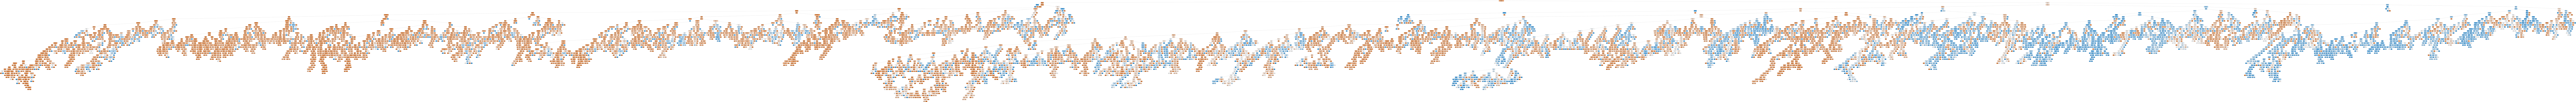

In [17]:
import graphviz 
# Import image display library for visualising trees
from IPython.display import Image

dot_data = tree.export_graphviz(tree_sel, out_file=None, feature_names=x_sel.columns, filled=True, rounded=True, class_names=cn) 
graph = graphviz.Source(dot_data)  
graph.render('big_tree', format="png")
Image(filename='big_tree.png')

I don't know about you, but that tree is a little bit too large. I also don't suggest you attempt to visualise the tree with all the attributes in the training set, it crashed my computer when I tried. Instead, we will construct multiple trees to find the maximum depth which produces the optimum results using 10 fold cross validation. We'll evaluate trees with a depth from 2 to 50 using 10 fold cross validation and plot the results to see if there there are any trends in classification efficiency, select the best depth for both trees, train them and then compare their efficiency using 10 fold cross validation. 

In [18]:
from sklearn.model_selection import GridSearchCV
depth_range = list(range(2, 50))
params = {"max_depth": depth_range}

# use 4 cores, set 10 fold cross validation and use classification accuracy as the metric
opt_sel = GridSearchCV(tree.DecisionTreeClassifier(random_state=1), params, n_jobs=4, cv=10, scoring="accuracy")
opt_all = GridSearchCV(tree.DecisionTreeClassifier(random_state=1), params, n_jobs=4, cv=10, scoring="accuracy")

opt_sel.fit(x_sel, y)
opt_all.fit(x_all, y)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=1), n_jobs=4,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                       24, 25, 26, 27, 28, 29, 30, 31, ...]},
             scoring='accuracy')

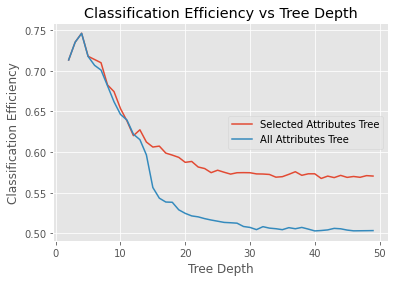

In [19]:
plt.plot(depth_range, opt_sel.cv_results_["mean_test_score"], label="Selected Attributes Tree")
plt.plot(depth_range, opt_all.cv_results_["mean_test_score"], label="All Attributes Tree")
plt.xlabel("Tree Depth")
plt.ylabel("Classification Efficiency")
plt.title("Classification Efficiency vs Tree Depth")
plt.legend(loc="center right")
plt.show()

In [20]:
print((discrete_df["income_bracket"] == "<=50K").value_counts())
print(f"Accuracy if you guess that everyone earns less than 50K: {round(24720 / len(discrete_df), 2)}")

True     24720
False     7841
Name: income_bracket, dtype: int64
Accuracy if you guess that everyone earns less than 50K: 0.76


Worryingly it appears that neither tree performs better than if we randomly guessed that everyone earns less than 50K, however we'll wait for the results of the 10 fold cross validation to be sure. In the meantime the plot reveals some interesting information. Firstly, the selected attributes tree performs similarly to the all attributes tree. This is logical as the selected tree includes only the columns from the original dataset which have a positive information gain, and are therefore useful to make predictions. Secondly, it is clear that the classification efficiency of both trees decreases dramatically with depth. Again, this is to be expected as deeper trees tend to be more overfitted than shallower trees.   

Let's perform 10 fold cross validation and compare their performance. 

In [21]:
from sklearn.model_selection import cross_val_score

sel_max_depth = opt_sel.best_params_["max_depth"]
all_max_depth = opt_all.best_params_["max_depth"]


opt_tree_sel = tree.DecisionTreeClassifier(random_state=1, max_depth=sel_max_depth)
opt_tree_all = tree.DecisionTreeClassifier(random_state=1, max_depth=all_max_depth)

sel_scores = cross_val_score(opt_tree_sel, x_sel, y, scoring="accuracy", cv=10, n_jobs=4)
all_scores = cross_val_score(opt_tree_sel, x_all, y, scoring="accuracy", cv=10, n_jobs=4)

print(f"Selected tree mean accuracy: {round(sel_scores.mean(), 2)}\n"
      f"Selected tree standard deviation accuracy: {round(sel_scores.std(), 2)}"
     )
print(
    f"All tree mean accuracy: {round(all_scores.mean(), 2)}\n"
    f"All tree standard deviation accuracy:{round(sel_scores.std(), 2)}"
)

Selected tree mean accuracy: 0.75
Selected tree standard deviation accuracy: 0.19
All tree mean accuracy: 0.75
All tree standard deviation accuracy:0.19


It appears that neither tree has a better classification accuracy than simply guessing that everyone earns less than 50K. This inefficiency is likely due to the binary encoding applied to the dataset. For classification sk-learn requires that categorical variables be binary encoded, and in the interests of implementation efficiency the continuous variables were also discretised and binary encoded. Despite efforts being made to do this in a logical manner (see data cleaning above), it introduced some imprecision in the dataset, which likely causes the tree to perform worse than trees constructed by other algorithms such as the J48 algorithm implemented in the Weka tool. 

Let's fit the trees with a test-train split, check the confusion matrix and visualise them to see what went wrong. 

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

x_new = discrete_df.copy()
y_new = discrete_df["income_bracket"]

# Set random state the same so the same test-train split is taken
x_sel_train, x_sel_test, y_sel_train, y_sel_test = train_test_split(x_sel, y, test_size=0.2, random_state=1)
x_all_train, x_all_test, y_all_train, y_all_test = train_test_split(x_all, y, test_size=0.2, random_state=1)


opt_tree_sel.fit(x_sel_train, y_sel_train)
opt_tree_all.fit(x_all_train, y_all_train)

sel_pred = opt_tree_sel.predict(x_sel_test)
all_pred = opt_tree_all.predict(x_all_test)


print("Selected tree results")
print("-------------------------------------------")
print(confusion_matrix(y_sel_test, sel_pred))
print(classification_report(y_sel_test, sel_pred))

print("All tree results")
print("-------------------------------------------")
print(confusion_matrix(y_all_test, all_pred))
print(classification_report(y_all_test, all_pred))




Selected tree results
-------------------------------------------
[[4541  411]
 [ 732  829]]
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      4952
           1       0.67      0.53      0.59      1561

    accuracy                           0.82      6513
   macro avg       0.76      0.72      0.74      6513
weighted avg       0.82      0.82      0.82      6513

All tree results
-------------------------------------------
[[4541  411]
 [ 732  829]]
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      4952
           1       0.67      0.53      0.59      1561

    accuracy                           0.82      6513
   macro avg       0.76      0.72      0.74      6513
weighted avg       0.82      0.82      0.82      6513



Unsurprisingly the results for both models are identical, and disappointing. 

Precision is the ratio of true positives to total positives and can be thought of intuitively as the tree's ability to not label something as positive that is negative. The lower the precision the more likely it is that the tree classifies an instance positively when it's in fact negative. For both trees the precision for predicting people earning less than 50K is reasonably high, indicating that the tree is good at identifying low income records, but suffers when it comes to accurately predicting high income records. 

Recall is the ratio of true positives to true positives and false negatives, and may be thought of the classifier's ability to find positive records. The lower the recall the less likely that the tree will correctly classify a positive record for a given class. As with the precision the recall of the trees for low income records is reasonably high, again indicating it is good at identifying low income records, whilst the recall for high income records is very poor. 

These trends may also be observed in the confusion matrices where half of the high income records are misclassified, compared to just under 10% of low income records.


Looking at the ```macro avg``` row, we see that the average precision is ```0.76```, which as calculated above is not any better than classifying all records as being low income.

Let's visualise the trees and see what's going on.


### Interpreting Decision Trees

Decision trees look like flowcharts, which is essentially what they are. At each level of a tree a decision is represented by an oval. Inside the oval the first line describes the decision, in our case all the attributes are binary encoded, so the decision is whether instances have the characteristic in question or not represented by ```<characteristic> <= 0.5``` where a response of "True" is interpreted as the instance not having the characteristic and a response of "False" indicating that the instance possesses the characteristic. The oval also contains the Gini index for the node, which indicates the level of impurity in the node. The Gini index represents the probability that if a random instance were chosen from the node that it would be misclassified. Thus, a Gini index of 0 indicates that all the instances in the node have been correctly classified, and higher values indicate a higher misclassification rate. Nodes also contain the number of observations of both classes that it contains, and the class that the decision tree has assigned the node. Finally the colour of a node provides a visual indicator of a node's class, with stronger colours indicating a predominance of one class in the node. 


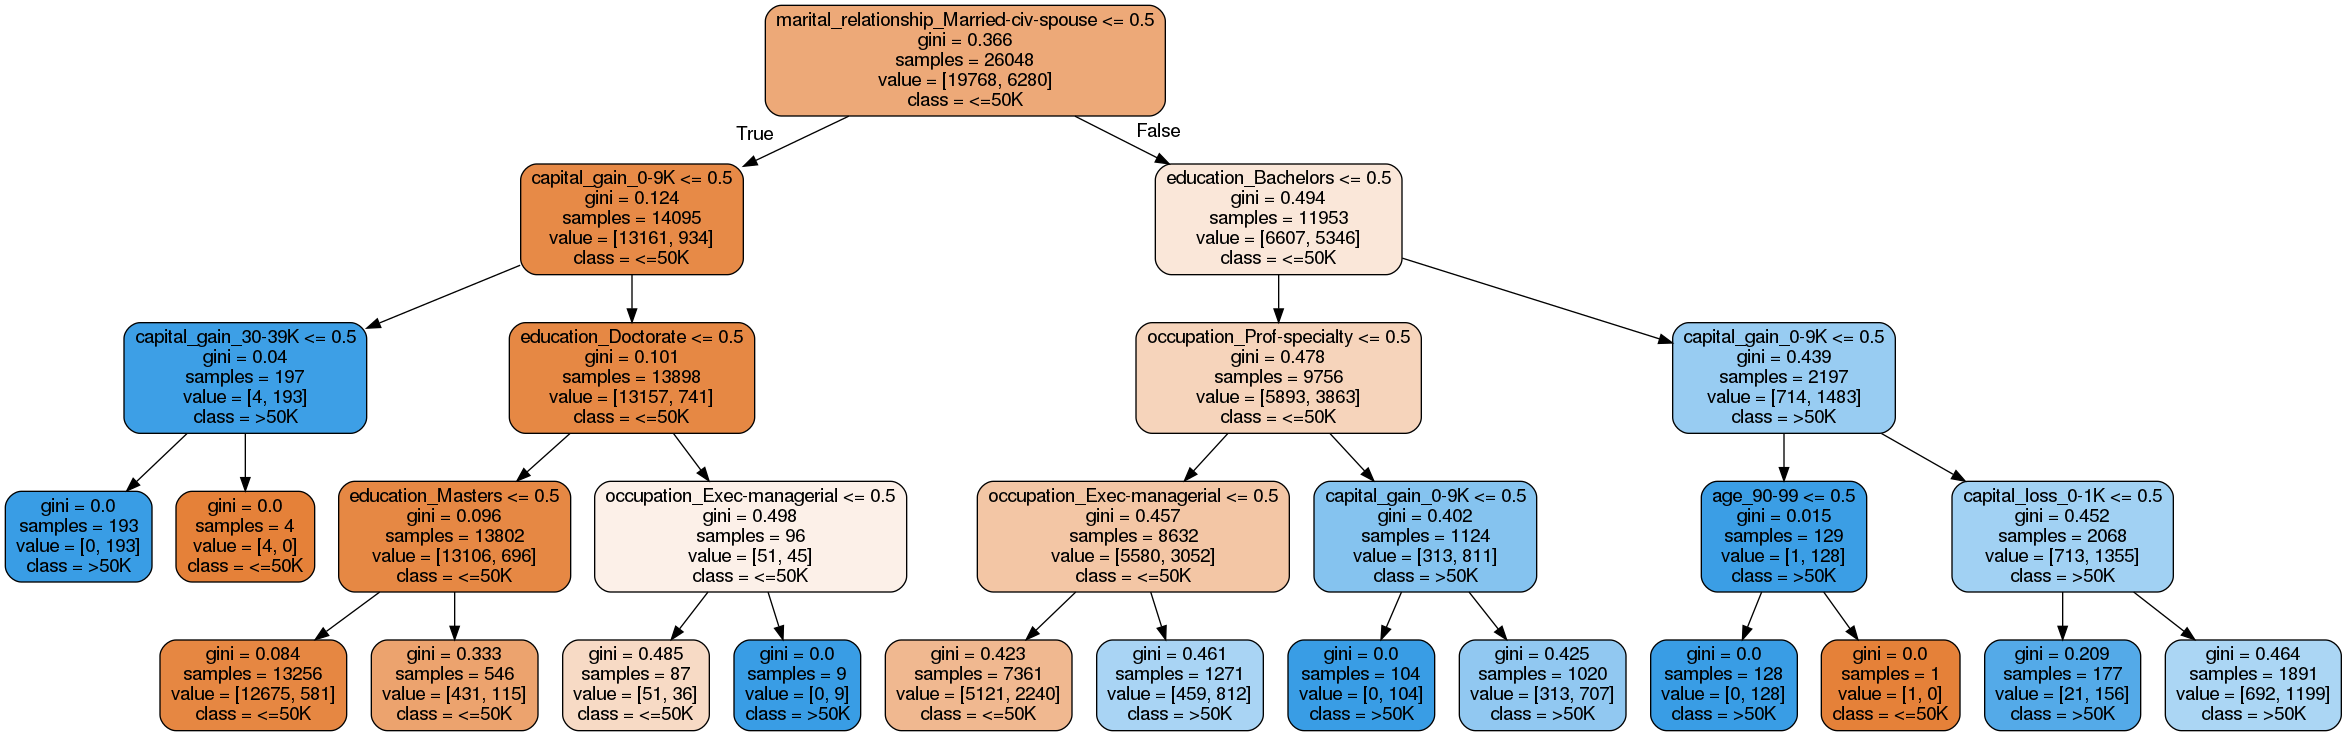

In [23]:
# Visualise the selected tree

dot_data = tree.export_graphviz(opt_tree_sel, out_file=None, feature_names=x_sel.columns, filled=True, rounded=True, class_names=cn) 
graph = graphviz.Source(dot_data)  
graph.render("selected_tree", format="png")
Image(filename='selected_tree.png')

#### Selected Tree

As we saw with the association rule mining, there appears to be a strong association between civilian marriage and higher incomes, with a large number of leaf nodes predicting incomes larger than 50K lying to the right of the root of the tree. Education also appears to play a larger role in determining income than we have found previously, with almost all the leaf nodes where a person has a bachelors degree being classified in the high income group (unless you happen to be aged 90-99). Interestingly the outlook is more bleak for people holding doctorates or masters degrees, with only those doctors holding executive or managerial positions being classified as higher income. The left most branch of the tree is particularly interesting as it shows that unmarried people with capital gains larger than 0-9K will be classified in the higher income group, providing they are not between the ages of 10-19. This suggests that large capital gains are a means of achieving higher incomes, a conclusion which makes intuitive sense. 




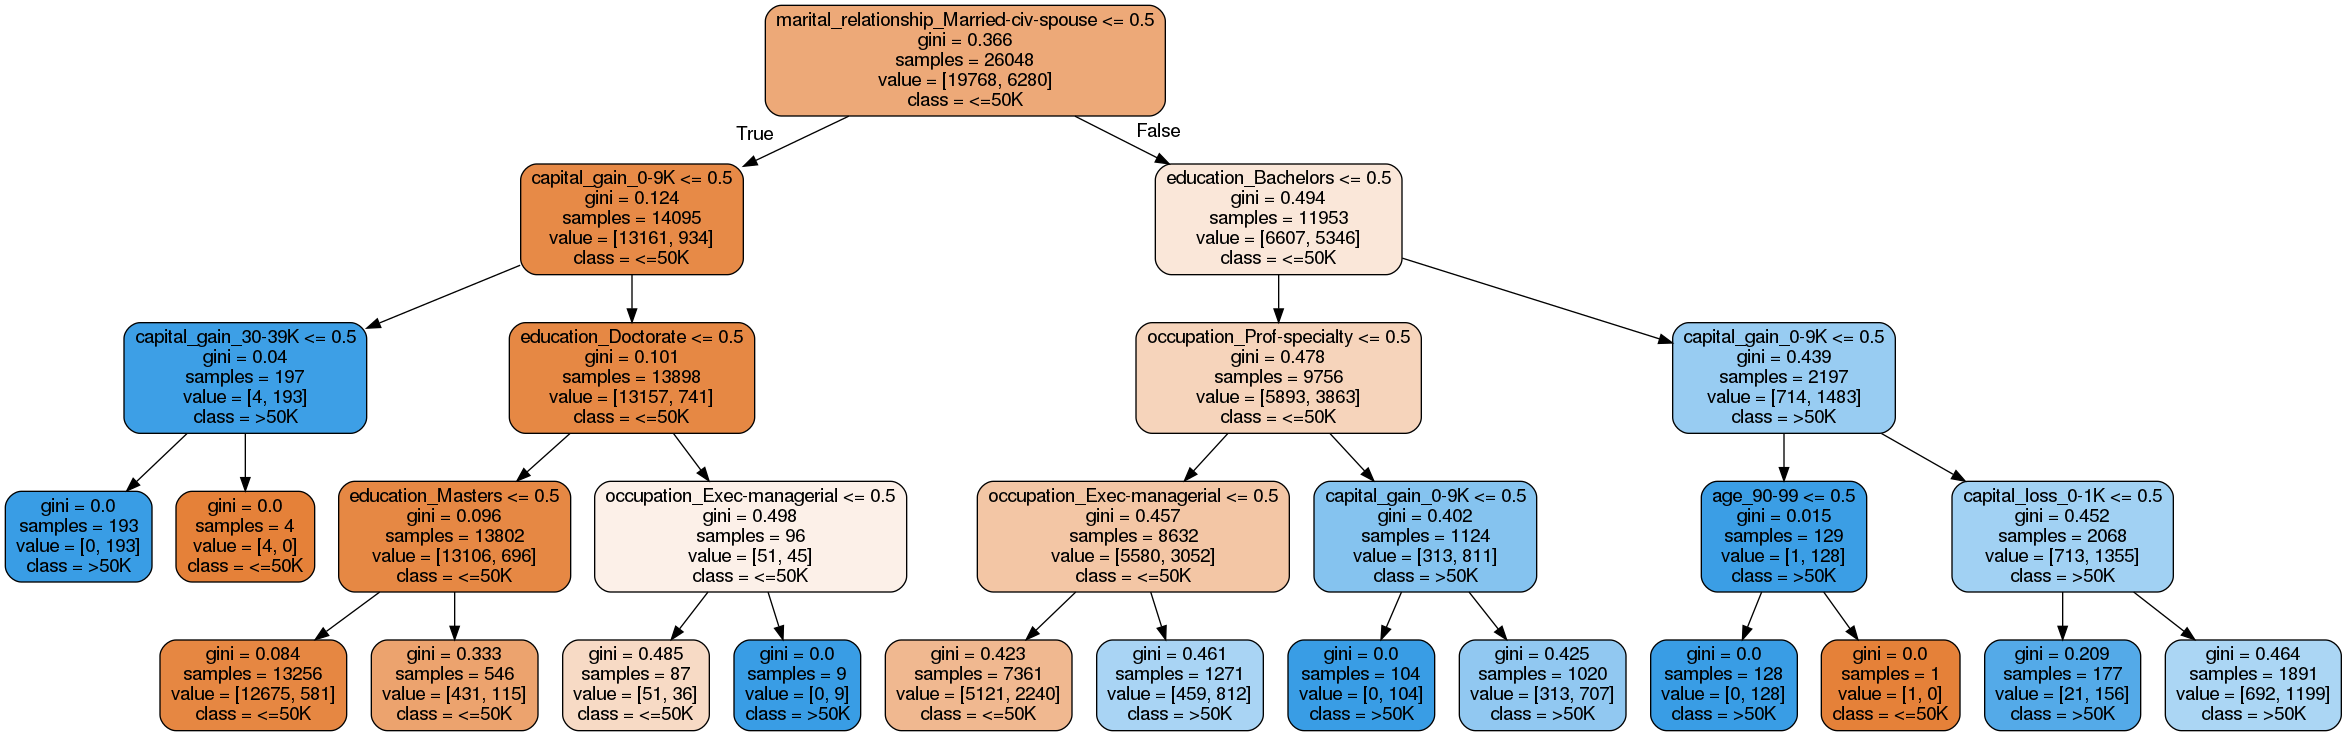

In [24]:
# Visualise the all attributes tree
dot_data = tree.export_graphviz(opt_tree_all, out_file=None, feature_names=x_all.columns, filled=True, rounded=True, class_names=cn) 
graph = graphviz.Source(dot_data)
graph.render("all_tree", format="png")
Image(filename='all_tree.png')

#### All Attributes Tree
The all attributes tree, as expected, is similar to the selected attributes tree, differing only on its left-most branch where having a capital gain larger than 0-9K, but not between 30-39K, appears to determine whether an unmarried person is classified as high income or not. 


### Random Forests

Because the decision trees constructed so far have been disappointing in their classification efficiency we will try constructing random forests for predicting a person's income bracket. Random forests is a classification technique that constructs multiple decision trees and uses a majority vote of these trees to classify new samples. In order to ensure that individual trees are distinct each tree is constructed using a bootstrap of the original dataset, and a subset of the available features are used to select the feature used to split the data at each level of the tree. To construct the random forest we will use the same approach as with the decision trees, we'll use ```GridSearchCV``` to find the best hyperparameters for the model, fit models for our selected dataset and the full dataset, and test them using 10 fold cross validation.  

In [25]:
from sklearn.ensemble import RandomForestClassifier
# Reduce depth range because I am too poor for AWS
depth_range = list(range(2, 10, 2))
tree_range = list(range(10, 30, 10))
rf_params = {
    "max_depth": depth_range,
    "max_features": ["sqrt"],
    "n_estimators": tree_range
}



rf_sel = GridSearchCV(RandomForestClassifier(random_state=1), rf_params, n_jobs=4, cv=10, scoring="accuracy")
rf_all = GridSearchCV(RandomForestClassifier(random_state=1), rf_params, n_jobs=4, cv=10, scoring="accuracy")


x_sel_rf = np.array(x_sel)
x_all_rf = np.array(x_all)
y_rf = np.array(y).ravel()


rf_sel.fit(x_sel_rf, y_rf)
rf_all.fit(x_all_rf, y_rf) 

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=1), n_jobs=4,
             param_grid={'max_depth': [2, 4, 6, 8], 'max_features': ['sqrt'],
                         'n_estimators': [10, 20]},
             scoring='accuracy')

In [26]:
print(rf_sel.best_params_)
print(max(rf_sel.cv_results_["mean_test_score"]))
print(rf_all.best_params_)
print(max(rf_all.cv_results_["mean_test_score"]))

{'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 10}
0.7743906056809035
{'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 20}
0.7776771859363202


Better than randomness by 2%, enormous. Let's build the trees using the optimal hyperparameters and perform 10 fold cross validation.

In [27]:
sel_hps = rf_sel.best_params_
all_hps = rf_all.best_params_

opt_rf_sel = RandomForestClassifier(random_state=1, max_depth=sel_hps["max_depth"], max_features="sqrt", n_estimators=sel_hps["n_estimators"])
opt_rf_all = RandomForestClassifier(random_state=1, max_depth=all_hps["max_depth"], max_features="sqrt", n_estimators=all_hps["n_estimators"])

rf_sel_scores = cross_val_score(opt_rf_sel, x_sel_rf, y_rf, scoring="accuracy", cv=10, n_jobs=4)
rf_all_scores = cross_val_score(opt_rf_sel, x_all_rf, y_rf, scoring="accuracy", cv=10, n_jobs=4)

print(f"Selected random forest mean accuracy: {round(rf_sel_scores.mean(), 2)}\n"
      f"Selected random forest standard deviation accuracy: {round(rf_sel_scores.std(), 2)}"
)
print(
    f"All random forest mean accuracy: {round(rf_all_scores.mean(), 2)}\n"
    f"All random forest standard deviation accuracy:{round(rf_sel_scores.std(), 2)}"
)

Selected random forest mean accuracy: 0.77
Selected random forest standard deviation accuracy: 0.05
All random forest mean accuracy: 0.77
All random forest standard deviation accuracy:0.05


Cross validation confirms the supremacy of the random forest, though not by much.

Just for completeness, let's look at the confusion matrices and classification report.

In [28]:
x_new = discrete_df.copy()
y_new = discrete_df["income_bracket"]

# Set random state the same so the same test-train split is taken
x_rf_sel_train, x_rf_sel_test, y_rf_sel_train, y_rf_sel_test = train_test_split(x_sel, y, test_size=0.2, random_state=1)
x_rf_all_train, x_rf_all_test, y_rf_all_train, y_rf_all_test = train_test_split(x_all, y, test_size=0.2, random_state=1)


x_rf_all_train = np.array(x_rf_all_train)
x_rf_sel_train = np.array(x_rf_sel_train)

y_rf_sel_train = y_rf_sel_train.values.ravel()
y_rf_all_train = y_rf_all_train.values.ravel()


opt_rf_sel.fit(x_rf_sel_train, y_rf_sel_train)
opt_rf_all.fit(x_rf_all_train, y_rf_all_train)

rf_sel_pred = opt_rf_sel.predict(x_rf_sel_test)
rf_all_pred = opt_rf_all.predict(x_rf_all_test)


print("Selected random forest results")
print("-------------------------------------------")
print(confusion_matrix(y_rf_sel_test, rf_sel_pred))
print(classification_report(y_rf_sel_test, rf_sel_pred))

print("All random forest results")
print("-------------------------------------------")
print(confusion_matrix(y_rf_all_test, rf_all_pred))
print(classification_report(y_rf_all_test, rf_all_pred))


Selected random forest results
-------------------------------------------
[[4782  170]
 [ 910  651]]
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      4952
           1       0.79      0.42      0.55      1561

    accuracy                           0.83      6513
   macro avg       0.82      0.69      0.72      6513
weighted avg       0.83      0.83      0.81      6513

All random forest results
-------------------------------------------
[[4907   45]
 [1261  300]]
              precision    recall  f1-score   support

           0       0.80      0.99      0.88      4952
           1       0.87      0.19      0.31      1561

    accuracy                           0.80      6513
   macro avg       0.83      0.59      0.60      6513
weighted avg       0.81      0.80      0.75      6513



Looking at the results we see a marked improvement in precision for predicting high income individuals, suggesting that the random forest models are better at differentiating between positive and negative records. Interestingly this change in precision is accompanied by a fall in recall, suggesting that the random forests models are better at determining whether a record is positive or negative, but are not better at finding positive records. 

Unfortunately, as random forests are a collection of decision trees visualising them is more difficult than individual decision trees. However, usually the trade-off in interpretability is worth the additional predictive power they provide, however in this case I am less certain.


If we were hell bent on using decision trees for classification our next stop would be gradient boosted trees, however, that's enough trees for one day, let's have a look at clustering algorithms to try and get some more insight on our data.

## Clustering

Cluster analysis is the task of grouping a set of objects in such a way that they share similar characteristics and is used to discover trends in data that may not be obvious otherwise. In the case of the income dataset, we are looking for characteristics associated with having an income larger than 50K. As clustering is an unsupervised technique, it is entirely possible that the clusters produced are the result of random trends in the dataset and reveal misleading patterns. As a result, extreme caution should be exercised when attempting to draw causal relationships on the basis of clusters. 

A standard algorithm for computing clusters is the k-means algorithm. The k-means algorithm starts by assigning k centres on the plane of the data and then repeatedly performs the following steps:
1. Compute the Euclidean distance between each data point and the centres of the clusters and assign the data point to the closest cluster.
2. Recalculate the centre of the cluster.

The termination condition for the algorithm is no change in the membership of the clusters. The k-means algorithm converges quickly to a local optimum, but does not produce the optimum solution as doing so is an NP-hard problem. 


However, given that our dataset is predominately categorical it would be inappropriate to use k-means.

An alternative algorithm is the k-modes algorithm first proposed by [Huange Zhexue](http://www.cs.ust.hk/~qyang/Teaching/537/Papers/huang98extensions.pdf) in 1998. Instead of computing the Euclidean distance between points the k-modes algorithm calculates distance between points using the number of matching categories between data points.

As our data is predominately categorical we will be using the k-modes algorithm to build clusters for our data. 

To perform the cluster analysis we will be using the ```kmodes``` library. If you need to install it run the cell below.

In [29]:
# import sys
# !{sys.executable} -m pip install kmodes 

Deciding the number of clusters to create is a key consideration when performing k-means or k-modes cluster analysis. Creating too many clusters will result in clusters that are too homogeneous to reveal interesting trends, having too few clusters will result in groups that are too heterogeneous to reveal any more trends than the dataset as a whole. Given that we are looking for the characteristics of high income earners, who comprise approximately 25% of the dataset, it is reasonable to expect that a four cluster analysis will reveal a cluster containing the high income bracket as a characteristic, provided that high income individuals are sufficiently distinct in the dataset. 

Let's construct a 2-mode cluster and a 4-mode cluster and check. 

In [44]:
from kmodes.kmodes  import KModes

kp_2 = KModes(n_clusters=2, init='Huang', n_init=5, verbose=1, n_jobs=4, random_state=1)
kp_2.fit_predict(discrete_df)

kp_4 = KModes(n_clusters=4, init='Huang', n_init=5, verbose=1, n_jobs=4, random_state=1)
kp_4.fit_predict(discrete_df)

print("Two centroid cluster\n")
print(kp_2.cluster_centroids_)
print()
print("Four centroid cluster\n")
print(kp_4.cluster_centroids_)

Best run was number 1
Best run was number 1
Two centroid cluster

[['0-9K' '0-1K' '40-49' 'M' '<=50K' '30-39' 'United-States' 'HS-grad'
  'White' 'Husband' 'Married-civ-spouse' 'Married' 'Private'
  'Craft-repair']
 ['0-9K' '0-1K' '40-49' 'F' '<=50K' '20-29' 'United-States' 'HS-grad'
  'White' 'Not-in-family' 'Never-married' 'Not Married' 'Private'
  'Adm-clerical']]
Four centroid cluster

[['0-9K' '0-1K' '40-49' 'M' '>50K' '40-49' 'United-States' 'HS-grad'
  'White' 'Husband' 'Married-civ-spouse' 'Married' 'Private'
  'Prof-specialty']
 ['0-9K' '0-1K' '40-49' 'M' '<=50K' '30-39' 'United-States'
  'Some-college' 'White' 'Husband' 'Married-civ-spouse' 'Married'
  'Private' 'Craft-repair']
 ['0-9K' '0-1K' '40-49' 'F' '<=50K' '20-29' 'United-States'
  'Some-college' 'White' 'Own-child' 'Never-married' 'Not Married'
  'Private' 'Adm-clerical']
 ['0-9K' '0-1K' '40-49' 'M' '<=50K' '40-49' 'United-States' 'HS-grad'
  'White' 'Not-in-family' 'Divorced' 'Not Married' 'Private'
  'Craft-repair']

As anticipated, the two centre cluster provides little insight as to the characteristics that are associated with high income earners, while the four centre cluster includes a cluster with a centroid featuring the >50K income bracket. 

In order to quantify how internally similar these clusters are and how distinct they are within the dataset we can use the k-modes definition of distance, the number of differences in characteristics, to calculate the mean deviation of each cluster, and the differences between each cluster and the centroids of the other clusters. We will also compute the most distinct object included in each cluster, that is to say the object furthest from the centroid.

In [31]:
from cluster import print_cluster_stats

labelled_df = discrete_df.copy()
labelled_df["label"] = kp_4.labels_

print_cluster_stats(labelled_df, kp_4.cluster_centroids_)

----------------------------------------
Centroid 0 deviations
----------------------------------------
Count 9389
Largest deviation: 9

Mean deviation to cluster 0 3.78
Mean deviation to cluster 1 4.82
Mean deviation to cluster 2 8.43
Mean deviation to cluster 3 7.04
----------------------------------------
Centroid 1 deviations
----------------------------------------
Count 6389
Largest deviation: 9

Mean deviation to cluster 0 4.99
Mean deviation to cluster 1 3.3
Mean deviation to cluster 2 7.31
Mean deviation to cluster 3 6.46
----------------------------------------
Centroid 2 deviations
----------------------------------------
Count 11139
Largest deviation: 10

Mean deviation to cluster 0 8.24
Mean deviation to cluster 1 7.17
Mean deviation to cluster 2 4.2
Mean deviation to cluster 3 5.96
----------------------------------------
Centroid 3 deviations
----------------------------------------
Count 5644
Largest deviation: 9

Mean deviation to cluster 0 7.22
Mean deviation to clust

Looking at the deviations above it appears that the four clusters are reasonably distinct, with the average deviation of any particular record being between 3.3 and 4.2, which is a reasonable performance for a cluster analysis performed across 14 characteristics. The most homogeneous cluster is cluster 1, followed by cluster 0. Interestingly these clusters are also the closest together, indicating that these clusters are the most similar. This shows that for people who are white, married, male, born in the US, with a high school education or above and who have modest capital gains and losses, the only differentiating characteristics are income, age and work type. This ***could*** suggest that age and work type are the factors determining the differences in income between these two groups, however a cluster analysis can't be used to draw definitive causal relationships, and it is equally possible that the difference between the two groups is solely due to income and the other differences in characteristics are the result of random variation.

Another way of analysing the differences between the high income group and the general population is to look at which characteristics are more common among the high income group than the general dataset. To perform this analysis we will add the labels to the original dataset, drop all instances which are not in the high income group and compare the proportions of each factor present in the high income group versus the general dataset. The cluster labels are numbered 0-3, and so we are looking for records with label 0. 

In [32]:
high_income_df = discrete_df.copy()
high_income_df["label"] = kp_4.labels_
high_income_df = high_income_df[high_income_df["label"] == 0]

print(
    f"Proportion of dataset classified as low income "
    f"{round((len(discrete_df) - len(high_income_df)) / len(discrete_df), 2)}"
)

Proportion of dataset classified as low income 0.71


Looking at the proportion of the dataset included in the low income clusters we can already see the cluster is not perfect, as the proportion of low income records in the original data set is approximately ```0.75```, however the remaining factor levels and their frequency will give some insight into what similarities exist between high income individuals.

In [33]:
from cluster import print_prev
for col in discrete_df.columns:
    print_prev(col, high_income_df, discrete_df)

Level prevalence report for factor capital_gain
----------------------------------------
Level Name                Count     Prevalence
----------------------------------------
High income prevalence

0-9K                            8825  0.940000
10-19K                           376  0.040000
90-99K                           135  0.010000
20-29K                            53  0.010000

----------------------------------------
Level Name                Count     Prevalence
----------------------------------------
Prevalence in general dataset

0-9K                           31791  0.980000
10-19K                           517  0.020000
90-99K                           159  0.000000
20-29K                            87  0.000000
30-39K                             5  0.000000
40-49K                             2  0.000000

Level prevalence report for factor capital_loss
----------------------------------------
Level Name                Count     Prevalence
-------------------------------

Level prevalence report for factor work_class
----------------------------------------
Level Name                Count     Prevalence
----------------------------------------
High income prevalence

Private                         5856  0.620000
Self-emp-not-inc                1010  0.110000
Local-gov                        739  0.080000
Self-emp-inc                     648  0.070000
State-gov                        424  0.050000
Federal-gov                      364  0.040000
?                                343  0.040000
Without-pay                        5  0.000000

----------------------------------------
Level Name                Count     Prevalence
----------------------------------------
Prevalence in general dataset

Private                        22696  0.700000
Self-emp-not-inc                2541  0.080000
Local-gov                       2093  0.060000
?                               1836  0.060000
State-gov                       1298  0.040000
Self-emp-inc                 

This comparison reveals some interesting trends:

* Working between 50 and 59 hours per week is more prevalent in the high income grouping, with 12% of people in the general dataset working those hours versus 18% of the high income group. Interestingly, the higher income group is less likely than the general dataset to work longer hours than that, however.

* Men are significantly over-represented in the high income dataset, comprising 88% of the group versus, 67% of the general dataset.

* The high income group is skewed towards older aged groups, with people aged 40 and 59 comprising 61% of the group, as opposed to 20% of the general dataset.

* Being a high school or bachelors degree graduate appears to be more frequent in the high income group, with 37% being high school graduates and 24% being bachelors graduates versus 32% and 16% in the general dataset.

* Whites are 5% over-represented in the high income group versus the general dataset.

* Husbands represent 85% of members of the high income group versus 41% of the dataset, indicating that not only is the high income group skewed towards men, it is also skewed towards married men.

* Marriage in general is also strongly associated with high incomes, with 97% of members of the high income group being married vs 53% of the general dataset.

* Prof-specialty and exec-managerial jobs are over-represented in the high income group by 10% and 8% respectively.


Finally, and most interestingly, the >50K income bracket accounts for 69% of records in the high income cluster versus only 24% of the general dataset. 

Revealing though these trends may be, some caution must be used as the high income cluster is a subset of the general dataset and thus some correlation is to be expected. If we wanted to have some certainty about whether the differences in characteristic prevalence revealed above reflect true differences between the two groups a test of statistical [significance](http://math.etsu.edu/1530/testing_proportion.pdf) could be used. However, this notebook is lengthy enough as it is and we still have to perform numerosity reduction and build an SVM.

## Data Reduction

Rarely do data scientists ever ask for less data, however the curse of dimensionality, where highly dimensional data becomes sparse and expensive to store and manipulate, and the need to have explainable associations often forces their hand. There are two approaches typically employed for data reduction - numerosity reduction and feature reduction. 


### Numerosity Reduction

Numerosity reduction involves replacing the original data representation with a smaller representation and may be achieved through parametric and non-parametric methods. Parametric numerosity reduction techniques include linear regression and log linear models, whose parameters can be stored instead of the full data representation. Non-parametric techniques include histograms, clustering, sampling and data cube aggregation.


### Feature Reduction

Feature reduction reduces the size of the dataset by reducing the number or size of attributes stored. Redundant features or features which provide little predictive power for the attribute of interest are eliminated. Principle component analysis (PCA) is a common feature reduction technique which projects axes into a n-dimensional space such that each axis maximises the variance in the data set. The axes represent principle components in the dataset, thus by excluding axes (PCs) with small variances, only a small quantity of explainable variance is eliminated from the dataset. In this way features that explain only a small portion of the variance in the response can be removed from the data without drastically reducing the predictive power of the remaining features. Because PCA relies upon variance as its metric for ranking components, it has limited application in datasets with predominately categorical variables such as this one, as variance is a poorly defined concept for binary encoded categorical variables.

Features may also be greedily selected, where a model is constructed by greedily adding features which provide the greatest increase in predictive power. Greedy attribute selection can be performed in the forward direction, building up a set of attributes from an empty set, terminating when n attributes have been selected or when the increase in predictive power drops below a particular threshold, or backwards, starting with model that includes all features and eliminating features which contribute little to the model's predictive power. Though effective, greedy feature selection is computationally expensive, and so without significantly more computational power than I possess I wouldn't attempt it. 

The two most appropriate feature selection techniques for this dataset are information gain and Chi-squared. We have already successfully used information gain to choose the most influential features for building decision trees, now we will look at Chi-squared. Chi-squared is a test of independence, that checks whether the co-occurrence of variables is proportionate to their frequency and assigns a probability indicating the likelihood that the co-occurrence is due to random chance. Chi-squared can be used for feature selection by finding out which categorical variables an outcome of interest is dependent upon, and removing any independent variables from the dataset. 


To test the effect of these data reduction techniques we will use sampling to produce a reduced dataset, use Chi-squared to perform feature reduction, and then construct an SVM model using both datasets and the original and compare the results using 10 fold cross validation. 

#### Creating the sampled dataset 

There are various approaches that can be used to create samples of a dataset including stratified sampling, simple random sampling, cluster sampling, and multi-stage sampling. For this dataset we will use simple random sampling to produce a dataset that is half the size of the original using sk-learn's ```train_test_split``` function.



In [34]:
one_hot_df = pd.get_dummies(discrete_df)
sampled_x = one_hot_df.sample(frac=0.5, random_state=1)
sampled_y = sampled_x["income_bracket_>50K"]
sampled_x.drop(["income_bracket_>50K", "income_bracket_<=50K"], axis=1, inplace=True)

one_hot_x = one_hot_df
one_hot_y = one_hot_x["income_bracket_>50K"]
one_hot_x.drop(["income_bracket_>50K", "income_bracket_<=50K"], axis=1, inplace=True)


sampled_x.head()

capital_gain_0-9K  capital_gain_10-19K  capital_gain_20-29K  \
9646                   1                    0                    0   
709                    0                    1                    0   
7385                   1                    0                    0   
16671                  1                    0                    0   
21932                  1                    0                    0   

       capital_gain_30-39K  capital_gain_40-49K  capital_gain_90-99K  \
9646                     0                    0                    0   
709                      0                    0                    0   
7385                     0                    0                    0   
16671                    0                    0                    0   
21932                    0                    0                    0   

       capital_loss_0-1K  capital_loss_1-2K  capital_loss_2-3K  \
9646                   1                  0                  0   
709                    1                  0                  0   
7385                   1                  0                  0   
16671                  1                  0                  0   
21932                  1                  0                  0   

       capital_loss_3-4K  ...  occupation_Farming-fishing  \
9646                   0  ...                           0   
709                    0  ...                           0   
7385                   0  ...                           0   
16671                  0  ...                           0   
21932                  0  ...                           0   

       occupation_Handlers-cleaners  occupation_Machine-op-inspct  \
9646                              0                             0   
709                               0                             0   
7385                              0                             0   
16671                             0                             0   
21932                             0                             0   

       occupation_Other-service  occupation_Priv-house-serv  \
9646                          0                           0   
709                           0                           0   
7385                          0                           0   
16671                         0                           0   
21932                         0                           0   

       occupation_Prof-specialty  occupation_Protective-serv  \
9646                           1                           0   
709                            0                           0   
7385                           0                           0   
16671                          0                           0   
21932                          0                           0   

       occupation_Sales  occupation_Tech-support  occupation_Transport-moving  
9646                  0                        0                            0  
709                   0                        0                            0  
7385                  0                        0                            0  
16671                 0                        0                            0  
21932                 0                        0                            1  

[5 rows x 134 columns]

Now let's use Chi-squared to find the best attributes. We'll use the ```SelectKBest``` function from sk-learn to find the top 60 attributes, as ranked by Chi-squared scores, a 50% reduction in features.  

In [35]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
chi_sq = SelectKBest(score_func=chi2, k=60)
chi_sq.fit(one_hot_x, one_hot_y)
chi_sq_x = chi_sq.transform(one_hot_x)

print(chi_sq_x.shape)

(32561, 60)


Now that the datasets have been prepared, let's build three SVMs using the three datasets and compare their performance using 10 fold CV.

Support Vector Machines (SVMs) are a classification tool which finds a hyperplane in n-dimensional space (for n features) that divides observations with the largest margin. This hyperplane is used as the decision boundary for a given response and can be used to classify new instances. 

In [41]:
from sklearn.svm import SVC
all_svm = SVC(random_state=1, kernel="rbf")
all_svm_sigmoid = SVC(random_state=1, kernel="sigmoid")

all_score = cross_val_score(all_svm, one_hot_x, one_hot_y, scoring="accuracy", cv=10, n_jobs=4)
all_score_sigmoid = cross_val_score(all_svm_sigmoid, one_hot_x, one_hot_y, scoring="accuracy", cv=10, n_jobs=4)

print(f"All SVM mean accuracy: {round(all_score.mean(), 2)}\n"
      f"All SVM standard deviation accuracy: {round(all_score.std(), 2)}"
)

print(f"All SVM sigmoid mean accuracy: {round(all_score_sigmoid.mean(), 2)}\n"
      f"All SVM sigmoid standard deviation accuracy: {round(all_score_sigmoid.std(), 2)}"
)

All SVM mean accuracy: 0.63
All SVM standard deviation accuracy: 0.2
All SVM sigmoid mean accuracy: 0.77
All SVM sigmoid standard deviation accuracy: 0.1


In [42]:
chi_sq_svm = SVC(random_state=1, kernel="rbf")
chi_sq_svm_sigmoid = SVC(random_state=1, kernel="sigmoid")

chi_sq_score = cross_val_score(chi_sq_svm, chi_sq_x, one_hot_y, scoring="accuracy", cv=10, n_jobs=4)
chi_sq_score_sigmoid = cross_val_score(chi_sq_svm_sigmoid, chi_sq_x, one_hot_y, scoring="accuracy", cv=10, n_jobs=4)

print(f"Chi-squared SVM mean accuracy: {round(chi_sq_score.mean(), 2)}\n"
      f"Chi-squared SVM standard deviation accuracy: {round(chi_sq_score.std(), 2)}"
)

print(f"Chi-squared sigmoid SVM mean accuracy: {round(chi_sq_score_sigmoid.mean(), 2)}\n"
      f"Chi-squared sigmoid SVM standard deviation accuracy: {round(chi_sq_score_sigmoid.std(), 2)}"
)

Chi-squared SVM mean accuracy: 0.66
Chi-squared SVM standard deviation accuracy: 0.19
Chi-squared sigmoid SVM mean accuracy: 0.78
Chi-squared sigmoid SVM standard deviation accuracy: 0.1


In [43]:
sampled_svm = SVC(random_state=1, kernel="rbf")
sampled_svm_sigmoid = SVC(random_state=1, kernel="sigmoid")

sampled_score = cross_val_score(sampled_svm, sampled_x, sampled_y, scoring="accuracy", cv=10, n_jobs=4)
sampled_score_sigmoid = cross_val_score(sampled_svm_sigmoid, sampled_x, sampled_y, scoring="accuracy", cv=10, n_jobs=4)

print(f"Sampled SVM mean accuracy: {round(sampled_score.mean(), 2)}\n"
      f"Sampled SVM standard deviation accuracy: {round(sampled_score.std(), 2)}"
)

print(f"Sampled SVM mean accuracy: {round(sampled_score_sigmoid.mean(), 2)}\n"
      f"Sampled SVM standard deviation accuracy: {round(sampled_score_sigmoid.std(), 2)}"
)

Sampled SVM mean accuracy: 0.85
Sampled SVM standard deviation accuracy: 0.01
Sampled SVM mean accuracy: 0.79
Sampled SVM standard deviation accuracy: 0.01


#### Interpreting the SVM 
SVMs use kernel functions to compute the support vectors used to produce the hyperplanes which divide datasets. The radial basis function (RBF) kernel is a standard kernel used in producing SVMs for classification, which when classifying new records relies heavily upon the classification of records that are close to the new record in the n-dimensional space. The sigmoid kernel is a non-parametric kernel function that classifies each point as a sum of the probabilities of its classifiers, summing to one. Thus, the sigmoid kernel takes a more global view when classifying new records. Other kernel functions such as linear kernels and polynomial kernels exist for SVMs, however linear kernels are rarely useful for classification problems, and the RBF is typically a more useful parametric kernel function than polynomial kernels.  

Interestingly, the SVM trained using the sampled dataset outperformed both the other classifiers. Though unexpected this efficiency is understandable as the classifier was trained on a reduced dataset that captured the essential trends of the original dataset, but had reduced variance and less noise. This reduced noise translated to an improved classification efficiency and more efficient classification using the RBF kernel, which weights similar records more highly when classifying new records. This effect can also be observed to an extent in the chi-squared selected classifier, which also had a better classification efficiency than the all records classifier, though still saw better performance with the sigmoid kernel function due to the number of rows in the dataset. 



# Conclusion

Having performed four types of data analysis, it is now possible to draw some conclusions about this dataset, and provide some advice to people wishing to increase their income. A consistent theme throughout this analysis has been the importance of marriage in having a higher income, the association between higher income and marriage was revealed in the association rule mining, the tree classification models and the cluster analysis. From the data it is difficult to derive whether marriage is a confounded variable, as married people tend to be older, which was also positively associated with higher income, however it is far and away the clearest association found in this dataset. Other less practical associations with high income that appeared across the analyses include being male, white, and born in the United States. Unfortunately, many of these characteristics are unchangeable and so provide little practical value to people wishing to increase their income. The cluster analysis and the decision trees also showed an association between Bachelors degrees and high school diplomas and higher incomes, however more investigation should be conducted to be certain of this association.

If this analysis were to be repeated I would advise that the decision trees be constructed using both continuous and categorical data as opposed to solely categorical data, as this likely reduced the classification efficiency of the trees.
